# Lab 5: Linear Models for Classification

The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We's see how well we can classify these with linear models. Let's start with looking at our data:

In [ ]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [2]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute);
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

<ipython-input-2-00dc9b2e0d7e>:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  fmnist = oml.datasets.get_dataset(40996)


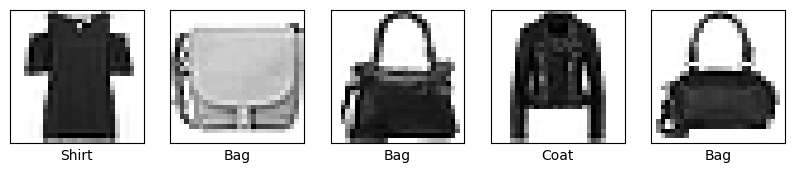

In [3]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[int(y.values[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

In [8]:
X.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exercise 1: A quick benchmark
First, we'll try the default [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [Linear SVMs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC). Click the links to read the documentation. We'll also compare it to [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as a point of reference. To see whether our models are overfitting, we also evaluate the training set error. This can be done using [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead of  [`cross_val_scores`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

For now we are just interested in a quick approximation, so we don't use the full dataset for our experiments. Instead, we use 10% of our samples:

In [9]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1)

With this small sample of our data we can now train and evaluate the three classifiers.

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below the function you will find example output.

In [10]:
from sklearn.model_selection import cross_validate

def evaluate_learners(classifiers, X, y):
    """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data.
      Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
      - a list with the scores obtained on the training samples for each classifier,
      - a list with the test scores obtained on the test samples for each classifier.
      The order of scores should match the order in which the classifiers were originally provided. E.g.:
      [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
    """
    train_scores, test_scores = [], []

    for model in classifiers:
      model_results = cross_validate(model, X, y, cv=5, n_jobs=-1, return_train_score=True)
      train_scores.append(model_results["train_score"])
      test_scores.append(model_results["test_score"])

    return train_scores, test_scores

### Exercise 1.2
Call the function you created with a Logistic Regression, Linear SVM, and k-Nearest Neighbors Classifier.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [11]:
classifiers = [LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

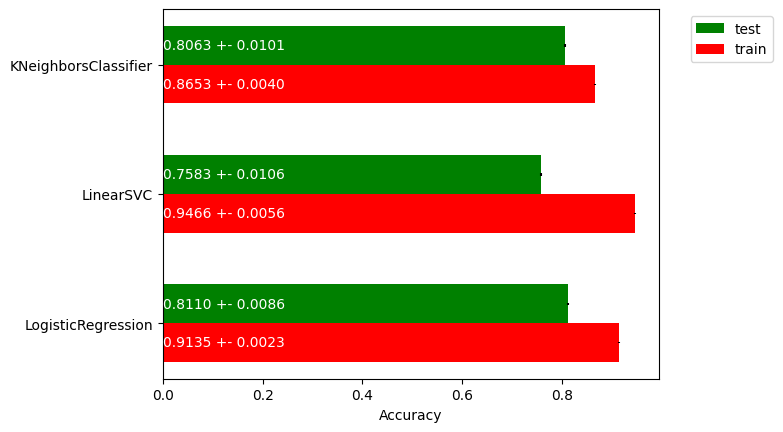

In [8]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. Which is the best classifier? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

**KNeighborsClassifier**
> Considering the KNeighborsClassifier, we see that the precision on the training data is around 0.86, while on the test data it is 0.80. The performance has is high and there is no too much difference between test and train: The model generalize well.

**LinearSVC**
> Regarding the LinearSVC, we see that performance on train is around 0.94. The performance has therefore significantly degraded from training to testing going to 0.75: There is overfitting. So we should do regularization.

**LogisticRegression**
> In the case of logistic regression, the difference between the test and training sets is little bit high, and the precision values are relatively high. Therefore, we can say that the model generalizes well. However, when comparing it to the KNeighborsClassifier, overfitting can be observed. So we should also make regularization.

NB: Where we realize that there is not a lot of variance in the results.

## Exercise 2: Regularization
We will now tune these algorithm's main regularization hyperparameter: the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. C should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]) and k should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the regularization parameters in the range given above and, for each classifier, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each classifier. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.


In [63]:
# let tune k for KNN
def knn_tuner(k_values, ax0):
  test_mean_score  = []
  train_mean_score = []

  for k in k_values:
    models = [KNeighborsClassifier(n_neighbors=k)]
    train_scores, test_scores = evaluate_learners(models, Xs, ys)
    test_mean_score.append(np.mean(test_scores[0]))
    train_mean_score.append(np.mean(train_scores[0]))

  ax0.plot(k_values, test_mean_score, label="test")
  ax0.plot(k_values, train_mean_score, label="train")
  best_k = k_values[np.argmax(test_mean_score)]
  best_score = max(test_mean_score)
  ax0.scatter(best_k, best_score, label=f"Best k={best_k}")
  ax0.set_title(f'KNN Classifier')
  ax0.set_xlabel('k values')
  ax0.legend()

# let alpha for logisticR and LinearSVC
def c_tuner(alpha_values, ax1, ax2):
  train_mean_score_lr = []
  test_mean_score_lr  = []
  train_mean_score_ls = []
  test_mean_score_ls  = []

  for c in alpha_values:
    models = [LogisticRegression(C=c), LinearSVC(C=c)]
    train_scores, test_scores = evaluate_learners(models, Xs, ys)
    train_mean_score_lr.append(np.mean(train_scores[0]))
    test_mean_score_lr.append(np.mean(test_scores[0]))
    train_mean_score_ls.append(np.mean(train_scores[1]))
    test_mean_score_ls.append(np.mean(test_scores[1]))

  ax1.plot(alpha_values, test_mean_score_lr,  label="test")
  ax1.plot(alpha_values, train_mean_score_lr, label="train")
  best_C_LR = alpha_values[np.argmax(test_mean_score_lr)]
  best_score = max(test_mean_score_lr)
  ax1.scatter(best_C_LR, best_score, label=f"Best C={best_C_LR:.0e}")
  ax1.set_title(f'LogisticRegression')
  ax1.set_xlabel('C values')
  ax1.set_xscale('log')
  ax1.legend()

  ax2.plot(alpha_values, test_mean_score_ls,  label="test")
  ax2.plot(alpha_values, train_mean_score_ls, label="train")
  best_C_LS = alpha_values[np.argmax(test_mean_score_ls)]
  best_score = max(test_mean_score_ls)
  ax2.scatter(best_C_LS, best_score, label=f"Best C={best_C_LS:.0e}")
  ax2.set_title(f'LinearSVC')
  ax2.set_xlabel('C values')
  ax2.set_xscale('log')
  ax2.legend()

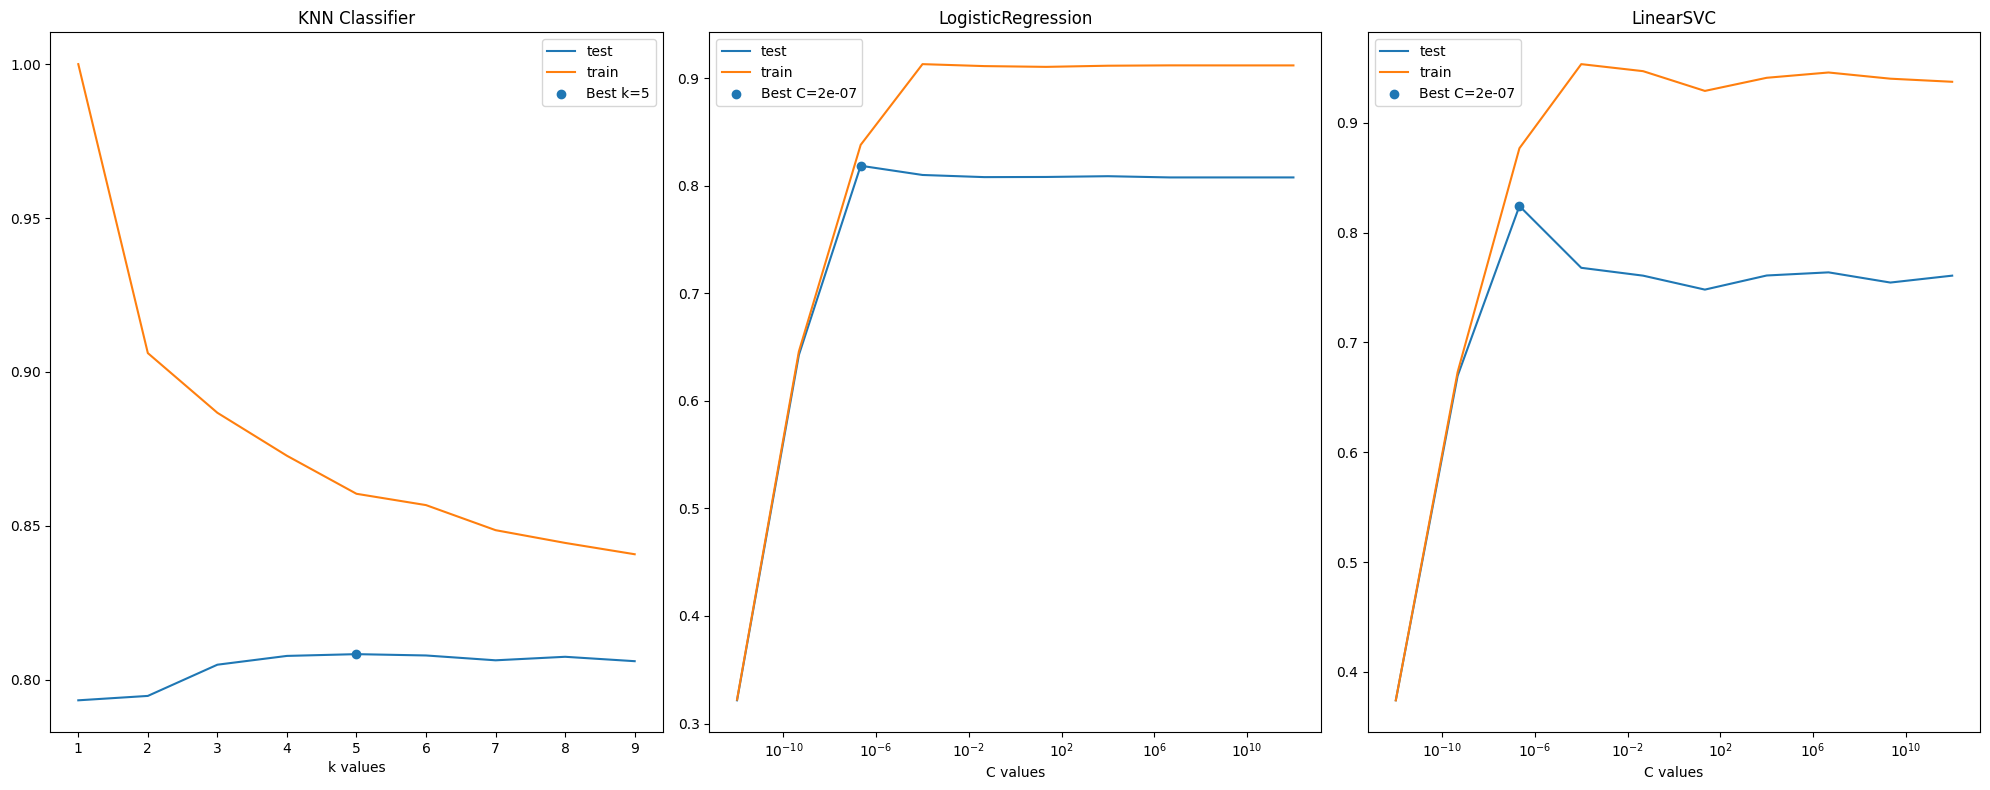

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

k_values = range(1, 10)
c_values = np.geomspace(1e-12, 1e12, num=10)
knn_tuner(k_values, axs[0])
c_tuner(c_values, axs[1], axs[2])

plt.tight_layout()
plt.show()

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

**KNN Classifier**
> The KNN model overfits for very small values of k. For k=5, it reaches its optimal value and provides a good balance between test and training accuracy. However, when we continue to tune for larger k values, it starts to underfit.

**LogisticRegression**
> For very small values, it underfits. It achieves good performance as C increases, and as we continue to tune by increasing C, it starts to overfit.

**LinearSVC**
> It has more or less the same behavior as Logistic Regression. The good thing is that we were able to improve the precision of the SVM.

## Exercise 3: Interpreting misclassifications
Chances are that your models are not yet perfect. It is important to understand what kind of errors it still makes. Let's take a closer look at which instances are misclassified and which classes are often confused.
Train the logistic regression model with `C=1e-7`. Train the model on a training set, and make predictions for a test set (both sets should be  sampled from our 10% subsample).

In [25]:
# Create a stratified train-test split on a sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

### Exercise 3.1
Train the classifier as described above, obtain the predictions `y_pred` on the test set, and identify all the misclassified samples `misclassified_samples`. Then, run the visualization code below to study the misclassifications

In [45]:
# Implement the code to obtain the actual predictions on the test set
logistic_model = LogisticRegression(C=1e-7)
logistic_model.fit(X_train,y_train)
y_pred = logistic_model.predict(X_test)

# Implement the code to obtain the indices of the misclassified samples
misclassified_samples = np.where(y_pred != y_test)[0]
print(misclassified_samples[:5])

[ 4 12 13 20 28]


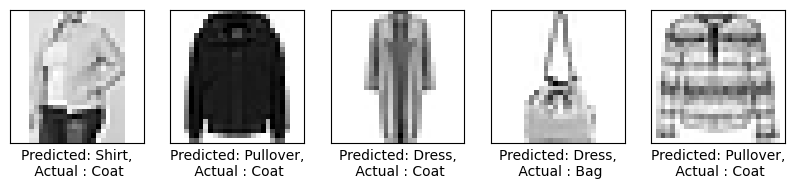

In [46]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test.values[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (fmnist_classes[int(y_pred[i])],fmnist_classes[int(y_test.values[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())
plt.show();

### Exercise 3.2
Interpret the results. Are these misclassifications to be expected?

**Interpretation**
> The images are of low quality, which could explain these errors. Additionally, some image can be misclassified by human in the dataset. Just an idea.


### Exercise 3.3.
Run the code below on your results to draw the complete confusion matrix and get more insight on the systematic misclassifications
of your model. A confusion matrix shows the amount of examples in for each pair of true and predicted classes. Interpret the results.
Does your model produce certain types of error more often than other types?

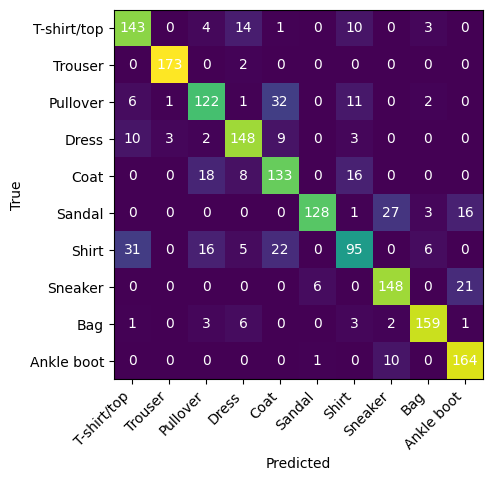

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

**Interpretation**
> We observe that trousers are often predicted correctly, as well as sandals and bags. However, T-shirts, pullovers, coats, and boots, among others, are often confused with other classes.

## Exercise 4: Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

### Exercise 4.1
Train a Logistic Regression model and a Linear SVM using their tuned hyperparameters from exercise 2.
When in doubt, use `C=1e-7` for LogReg and `C=1e-8` for the SVM.
Pass the trained model to the provided plotting function. Interpret the results in detail.
Why do you get multiple plots per model? What do the features represent in your data.
Does it seems like the models pay attention to the right features?
Do you models seem to ignore certain features? Do you observe differences in quality between the different classes? Do you observe any differences between the models?

In [51]:
# Plots the coefficients of the given model as 28x28 heatmaps.
# The `name` attribute is optional, it is simply a title for the produced figure
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())

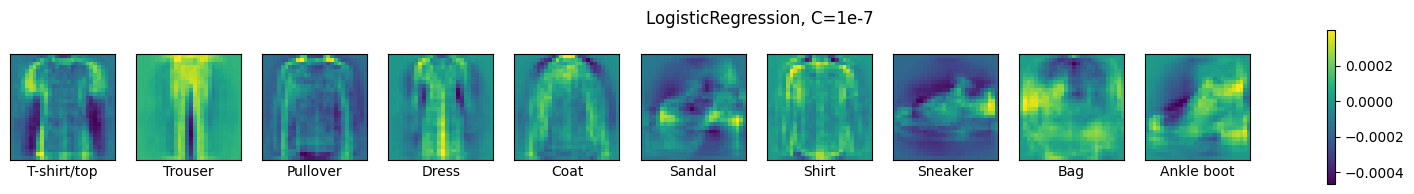

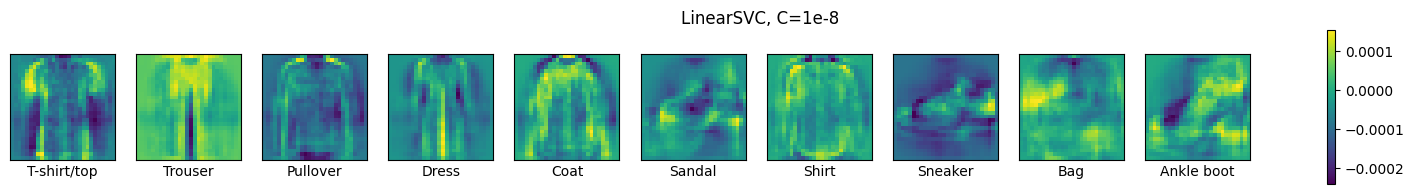

In [66]:
# LOGISTIC MODEL
model1 = LogisticRegression(C=1e-7)
model1.fit(X_train,y_train)
plot_coefficients(model1, "LogisticRegression, C=1e-7")

# LINEAR SVM MODEL
model2 = LinearSVC(C=1e-8)
model2.fit(X_train,y_train)
plot_coefficients(model2, "LinearSVC, C=1e-8")

**Interpretation**
> - Why do you get multiple plots per model?<br>
> LinearRegressiona and Linear SVC are logistic regressor. This mean. that they can predict only binary classes. As in our study we have 10 classe each model will contain 10 weight. each corresponding to the identification of a specific classe. Therefore we represent each weigh as 28by28 image. That why we have 10 image per model
> - What do the features represent in your data<br>
> An image pixel
> - Does it seems like the models pay attention to the right features? <br>
> Most image are identified by the model by the high value pixel on they edge. And sometime by the black one in the object. So we can say that yes it's working.
> - Do you models seem to ignore certain features? <br>
> Yes, for example, for bags and sandals, we cannot clearly identify them on the plot. So the model does not have enough data to learn efficiently their characteristics
> - Do you observe differences in quality between the different classes? <br>
> Yes, there is a little bit of difference between models. But they are still very close, except that SVM uses poor quality of pixels.
> - Do you observe any differences between the models? <br>
> By the right side, we can see that SVM coefficient values range from 0.0001 to -0.0002, but for Logistic Regression, they range from 0.0002 to -0.0004."




### Exercise 4.2
Repeat the previous exercise, but now only with logistic regression. In addition to a tuned version, also add a model that overfits a lot and one that underfits a lot. Interpret and explain the results.

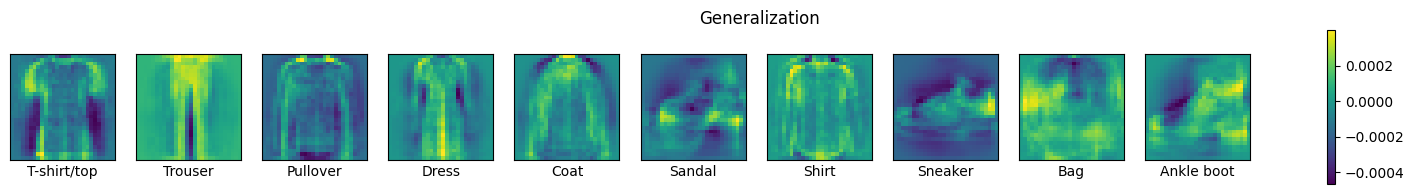

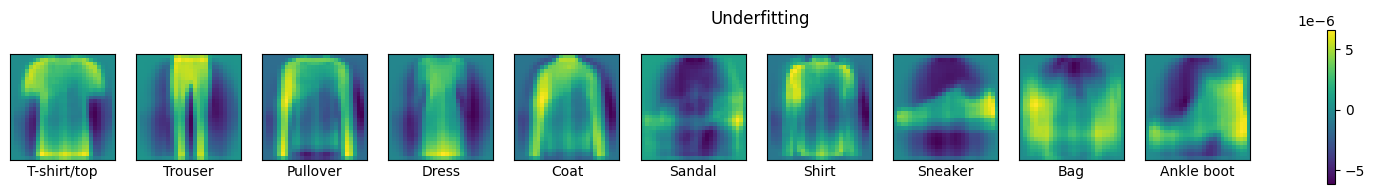

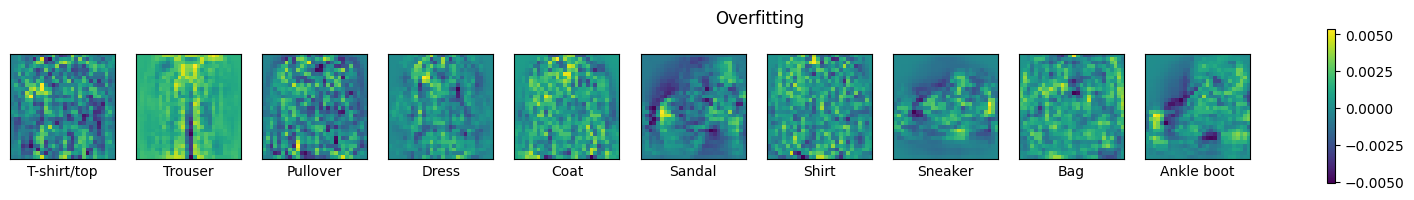

In [58]:
# TUNED VERSION MODEL
model4 = LogisticRegression(C=2e-7)
model4.fit(X_train,y_train)
plot_coefficients(model4, "Generalization")

# UNDERFITING MODEL
model3 = LogisticRegression(C=1e-10)
model3.fit(X_train,y_train)
plot_coefficients(model3, "Underfitting")

# OVERFITTING MODEL
model5 = LogisticRegression(C=1e+10)
model5.fit(X_train,y_train)
plot_coefficients(model5, "Overfitting")

**Interpretation**
> - Underfitting
> In the case of underfitting, the model focuses on very bright pixels at the edges and sometimes very dark pixels at the edges. Therefore, to identify shapes, it would focus on the edges, explaining why the model's weights are very low.
> - Overfitting
> In this case, the model appears to focus on a random mixture of white and black inside the object to be identified. This justifies the high weights.


In [ ]:
# END LAB - GÉNÉREUX AKOTENOU